In [1]:
import pandas as pd

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 70)

playerFrames = pd.read_csv('../scrape-parse/demo/parse/2023/playerFrames/blast-premier-fall-groups-2023-big-vs-astralis-bo3-AJ6pTg2cD4u8jKjNk-bhJKbig-vs-astralis-m2-ancient.dem.csv')

pf = playerFrames[['tick', 'roundNum', 'seconds', 'side', 'name', 'x', 'y', 'z',
    'eyeX', 'eyeY', 'eyeZ', 'velocityX', 'velocityY', 'velocityZ',
    'hp', 'armor', 'activeWeapon',
    'flashGrenades', 'smokeGrenades', 'heGrenades', 'totalUtility',
    'isAlive', 'isReloading', 'isDefusing', 'isPlanting', 'isUnknown',
    'equipmentValue', 'equipmentValueRoundStart', 'hasHelmet',
    'hasDefuse', 'hasBomb'
    ]]

rounds = pd.read_csv('../scrape-parse/demo/parse/2023/rounds/blast-premier-fall-groups-2023-big-vs-astralis-bo3-AJ6pTg2cD4u8jKjNk-bhJKbig-vs-astralis-m2-ancient.dem.csv')
rounds = rounds[['roundNum', 'tScore', "ctScore" ,'endTScore', 'endCTScore']]

kills = pd.read_csv("../scrape-parse/demo/parse/2023/kills/blast-premier-fall-groups-2023-big-vs-astralis-bo3-AJ6pTg2cD4u8jKjNk-bhJKbig-vs-astralis-m2-ancient.dem.csv")

pf = pf.merge(rounds, on='roundNum')
pf["winsRounds"] = pf.apply(lambda x: 
    1 if ( (x['side'] == 'T') and (x['endTScore'] > x['tScore']) ) or ( (x['side'] == 'CT') and (x['endCTScore'] > x['ctScore']) )
    else 0, axis=1)

pf['kills'] = 0
pf['deaths'] = 0

for index, row in kills.iterrows():
    pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['attackerName']), 'kills'] += 1
    pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['victimName']), 'deaths'] += 1

pf.loc[pf['name'] == 'Buzz']

,tick,roundNum,seconds,side,name,x,y,z,eyeX,eyeY,eyeZ,velocityX,velocityY,velocityZ,hp,armor,activeWeapon,flashGrenades,smokeGrenades,heGrenades,totalUtility,isAlive,isReloading,isDefusing,isPlanting,isUnknown,equipmentValue,equipmentValueRoundStart,hasHelmet,hasDefuse,hasBomb,tScore,ctScore,endTScore,endCTScore,winsRounds,kills,deaths
8,8685,1,0.117188,T,Buzz,-437.512848,-2335.330078,-163.255753,-437.512848,-2335.330078,-99.193192,-86.079056,10.278288,0.000000,100,0,Knife,0,0,0,0,True,False,False,False,False,900,200,False,False,False,0,0,1,0,1,0,0
15,8701,1,0.242188,T,Buzz,-453.213165,-2333.562500,-163.255753,-453.213165,-2333.562500,-99.193192,-155.194717,16.633657,0.000000,100,0,Knife,0,0,0,0,True,False,False,False,False,900,200,False,False,False,0,0,1,0,1,0,0
28,8717,1,0.367188,T,Buzz,-475.634644,-2331.301270,-163.255753,-475.634644,-2331.301270,-99.193192,-197.463318,19.016655,0.000000,100,0,Knife,0,0,0,0,True,False,False,False,False,900,200,False,False,False,0,0,1,0,1,0,0
38,8733,1,0.492188,T,Buzz,-502.160858,-2328.826416,-163.255753,-502.160858,-2328.826416,-99.193192,-223.217072,20.579199,0.000000,100,0,Knife,0,0,0,0,True,False,False,False,False,900,200,False,False,False,0,0,1,0,1,0,0
48,8749,1,0.617188,T,Buzz,-531.155579,-2325.920410,-163.255753,-531.155579,-2325.920410,-99.193192,-238.204697,27.241087,0.000000,100,0,Knife,0,0,0,0,True,False,False,False,False,900,200,False,False,False,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222864,487868,26,21.664062,CT,Buzz,-678.487122,-125.157410,59.345699,-919.021606,1135.302734,135.303207,119.529289,-25.433609,0.000000,0,0,NaN,0,0,0,0,False,False,False,False,False,4950,200,False,False,False,15,10,16,10,0,20,18
222871,487884,26,21.789062,CT,Buzz,-678.487122,-125.157410,59.345699,-906.263245,1126.729248,134.399223,81.965324,-98.090469,0.000000,0,0,NaN,0,0,0,0,False,False,False,False,False,4950,200,False,False,False,15,10,16,10,0,20,18
222883,487900,26,21.914062,CT,Buzz,-678.487122,-125.157410,59.345699,-896.326233,1114.000610,162.071266,79.427788,-101.945000,211.368378,0,0,NaN,0,0,0,0,False,False,False,False,False,4950,200,False,False,False,15,10,16,10,0,20,18
222890,487916,26,22.039062,CT,Buzz,-678.487122,-125.157410,59.345699,-889.591431,1098.533569,182.242157,42.499104,-132.200958,111.368378,0,0,NaN,0,0,0,0,False,False,False,False,False,4950,200,False,False,False,15,10,16,10,0,20,18


<BarContainer object of 23 artists>

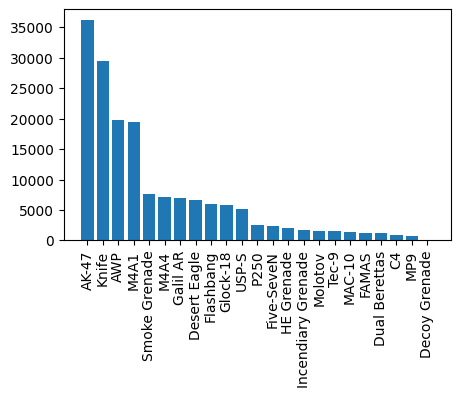

In [2]:
import matplotlib.pyplot as plt

asd = pd.DataFrame([pf.activeWeapon.value_counts().sort_values(ascending=False).index, pf.activeWeapon.value_counts().sort_values(ascending=False).values]).T
fig = plt.figure(figsize=(5, 3))
plt.xticks(rotation=90)
plt.bar(asd[0], asd[1])

In [4]:
dummies = pd.get_dummies(pf['activeWeapon'], prefix="activeWeapon",drop_first=False)[['activeWeapon_AK-47','activeWeapon_Knife','activeWeapon_AWP','activeWeapon_M4A1','activeWeapon_Smoke Grenade','activeWeapon_M4A4','activeWeapon_Galil AR','activeWeapon_Desert Eagle','activeWeapon_Flashbang','activeWeapon_Glock-18','activeWeapon_USP-S']]
dummies = dummies*1
pf = pf.merge(dummies, left_index = True, right_index = True, how = 'left')
pf.head(2)

,tick,roundNum,seconds,side,name,x,y,z,eyeX,eyeY,eyeZ,velocityX,velocityY,velocityZ,hp,armor,activeWeapon,flashGrenades,smokeGrenades,heGrenades,totalUtility,isAlive,isReloading,isDefusing,isPlanting,isUnknown,equipmentValue,equipmentValueRoundStart,hasHelmet,hasDefuse,hasBomb,tScore,ctScore,endTScore,endCTScore,winsRounds,kills,deaths,activeWeapon_AK-47_x,activeWeapon_Knife_x,activeWeapon_AWP_x,activeWeapon_M4A1_x,activeWeapon_Smoke Grenade_x,activeWeapon_M4A4_x,activeWeapon_Galil AR_x,activeWeapon_Desert Eagle_x,activeWeapon_Flashbang_x,activeWeapon_Glock-18_x,activeWeapon_USP-S_x,activeWeapon_AK-47_y,activeWeapon_Knife_y,activeWeapon_AWP_y,activeWeapon_M4A1_y,activeWeapon_Smoke Grenade_y,activeWeapon_M4A4_y,activeWeapon_Galil AR_y,activeWeapon_Desert Eagle_y,activeWeapon_Flashbang_y,activeWeapon_Glock-18_y,activeWeapon_USP-S_y
0,8685,1,0.117188,CT,s1n,-430.607147,1688.966064,27.320375,-430.607147,1688.966064,91.382936,21.685839,-108.023254,0.0,100,0,Flashbang,1,0,0,1,True,False,False,False,False,400,200,False,False,False,0,0,1,0,0,0,0,False,False,False,False,False,False,False,False,True,False,False,0,0,0,0,0,0,0,0,1,0,0
1,8685,1,0.117188,CT,tabseN,-222.246323,1737.048462,25.823181,-222.246323,1737.048462,89.885742,25.317469,-107.203705,0.0,100,100,Flashbang,1,1,0,2,True,False,False,False,False,1350,200,False,False,False,0,0,1,0,0,0,0,False,False,False,False,False,False,False,False,True,False,False,0,0,0,0,0,0,0,0,1,0,0
